Rows (SDAC merge): 35126  | Rows (EXAA merge): 35126


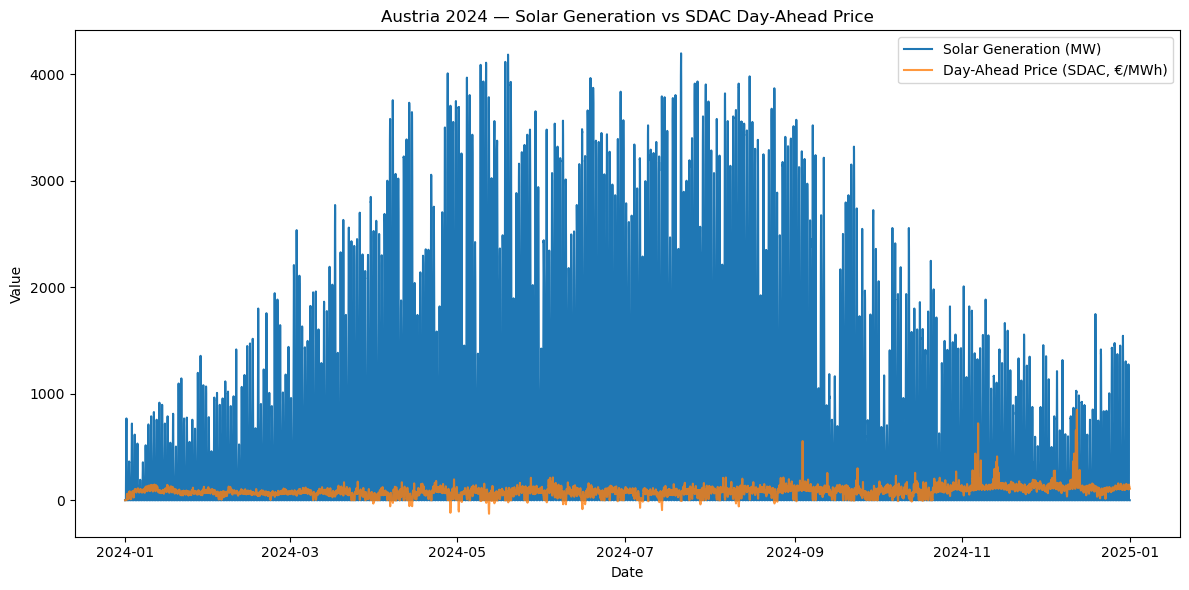

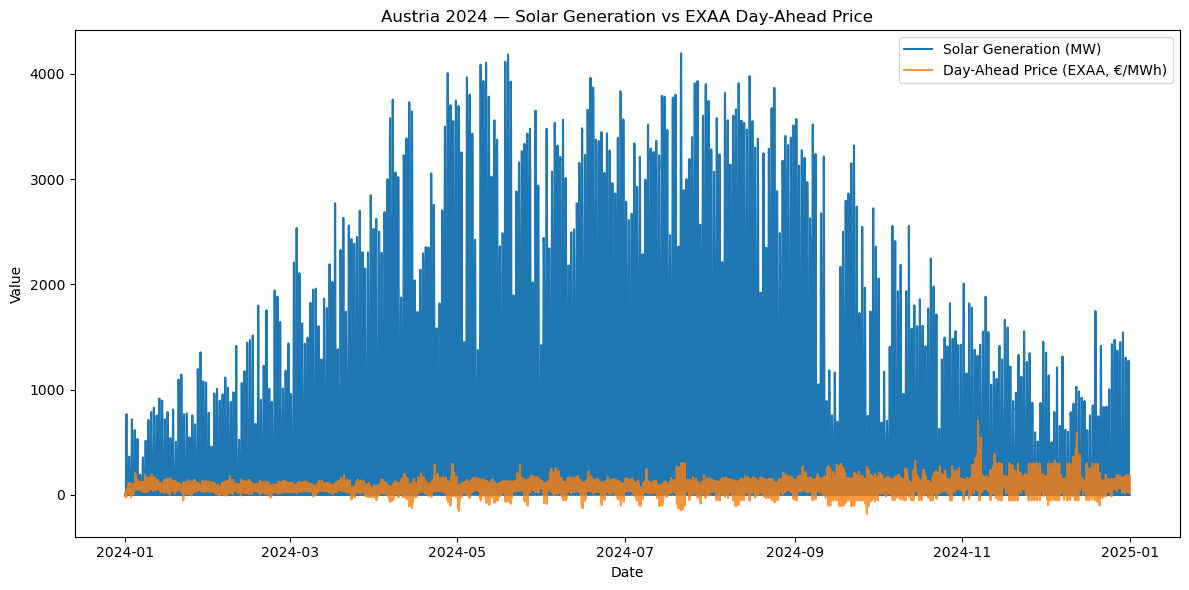

Correlation (Solar vs SDAC Price): -0.409
Correlation (Solar vs EXAA Price): -0.376


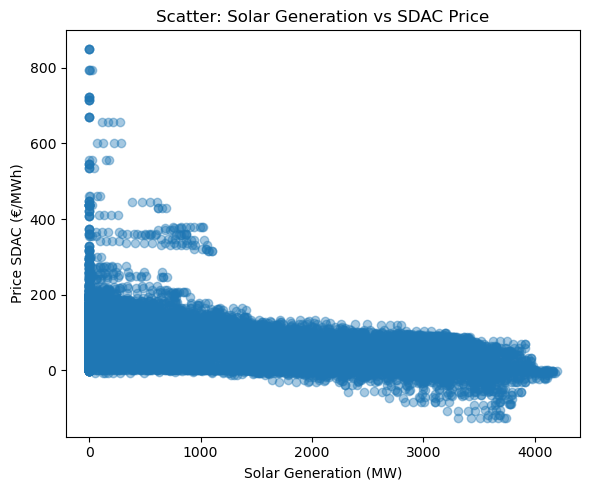

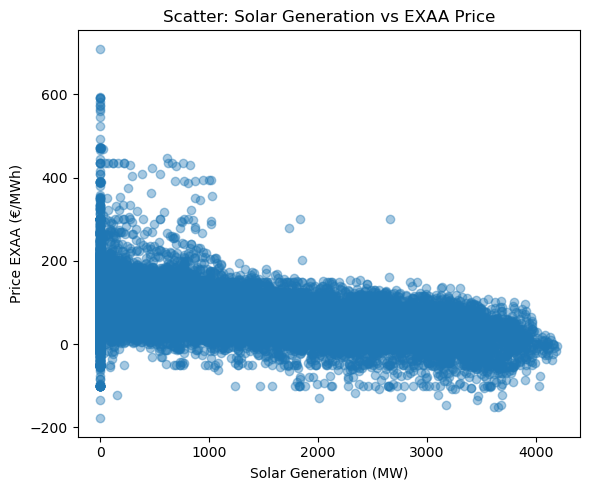

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ========= CONFIG: set your file paths here =========
GEN_PATH   = "generation_AT_2024.csv"
PRICE_PATH = "price_AT_2024.csv"
BIDDING_ZONE = "BZN|AT"   # Austria
# ====================================================

def read_any_csv(path):
    """Read CSV with auto-detected separator and quoted headers."""
    return pd.read_csv(path, sep=None, engine="python")

def pick_col(cols, *candidates):
    """Return the first column whose name contains ANY of candidates (case-insensitive)."""
    lc = {c.lower(): c for c in cols}
    for c in cols:
        pass
    for cand in candidates:
        for col in cols:
            if cand.lower() in col.lower():
                return col
    raise KeyError(f"None of {candidates} found in columns: {list(cols)}")

# -----------------------
# 1) LOAD DATA
# -----------------------
gen_df   = read_any_csv(GEN_PATH)
price_df = read_any_csv(PRICE_PATH)

# -----------------------
# 2) IDENTIFY COLUMNS
# -----------------------
# GENERATION file typical columns: "MTU (CET/CEST)", "Area", "Production Type", "Generation (MW)"
gen_period_col = pick_col(gen_df.columns, "MTU", "Time", "Period")
gen_area_col   = pick_col(gen_df.columns, "Area", "MapCode", "Bidding", "Zone")
gen_type_col   = pick_col(gen_df.columns, "Production Type", "ProductionType", "Type")
gen_value_col  = pick_col(gen_df.columns, "Generation (MW)", "Actual", "Value")

# PRICE file typical columns: "MTU (CET/CEST)", "Area", "Price category" (or contains 'Sequence'), "Price [EUR/MWh]"
price_period_col = pick_col(price_df.columns, "MTU", "Time", "Period")
price_area_col   = pick_col(price_df.columns, "Area", "MapCode", "Bidding", "Zone")
# This often looks like "Price category" with texts like "Sequence Sequence 1/2"
price_seq_col    = pick_col(price_df.columns, "Sequence", "Price category", "Auction", "Market")
price_value_col  = pick_col(price_df.columns, "EUR/MWh", "Price", "Price [EUR/MWh]")

# -----------------------
# 3) CLEAN & PARSE TIMES
# -----------------------
def extract_start(series):
    # Split "start - end" and parse start; handle stray spaces
    start_str = series.astype(str).str.split(" - ").str[0].str.strip()
    return pd.to_datetime(start_str, dayfirst=True, errors="coerce")

# Generation
gen_df = gen_df.copy()
gen_df["Start"] = extract_start(gen_df[gen_period_col])

# Price
price_df = price_df.copy()
price_df["Start"] = extract_start(price_df[price_period_col])

# Filter valid timestamps and the bidding zone
gen_df   = gen_df[gen_df["Start"].notna()]
price_df = price_df[price_df["Start"].notna()]

gen_df   = gen_df[gen_df[gen_area_col] == BIDDING_ZONE]
price_df = price_df[price_df[price_area_col] == BIDDING_ZONE]

# -----------------------
# 4) SOLAR GENERATION (MW)
# -----------------------
solar_df = gen_df[gen_df[gen_type_col].astype(str).str.contains("Solar", case=False, na=False)].copy()

# Some files may have numeric with commas; coerce safely
solar_df["Solar_Generation_MW"] = pd.to_numeric(solar_df[gen_value_col].astype(str).str.replace(",", "."), errors="coerce")

solar_df = solar_df[["Start", "Solar_Generation_MW"]].groupby("Start", as_index=False).sum()

# -----------------------
# 5) SPLIT PRICES: SDAC vs EXAA
# -----------------------
price_df["SequenceNorm"] = price_df[price_seq_col].astype(str).str.lower()

sdac_mask = price_df["SequenceNorm"].str.contains("sequence 1") | price_df["SequenceNorm"].str.contains("sdac")
exaa_mask = price_df["SequenceNorm"].str.contains("sequence 2") | price_df["SequenceNorm"].str.contains("exaa")

price_df["Price"] = pd.to_numeric(price_df[price_value_col].astype(str).str.replace(",", "."), errors="coerce")

price_sdac = price_df[sdac_mask][["Start", "Price"]].rename(columns={"Price": "Price_SDAC"}).dropna()
price_exaa = price_df[exaa_mask][["Start", "Price"]].rename(columns={"Price": "Price_EXAA"}).dropna()

# If some rows carry both sequences at the same timestamp, ensure uniqueness:
price_sdac = price_sdac.groupby("Start", as_index=False).mean()
price_exaa = price_exaa.groupby("Start", as_index=False).mean()

# -----------------------
# 6) MERGE
# -----------------------
merged_sdac = pd.merge(solar_df, price_sdac, on="Start", how="inner").sort_values("Start")
merged_exaa = pd.merge(solar_df, price_exaa, on="Start", how="inner").sort_values("Start")

print("Rows (SDAC merge):", len(merged_sdac), " | Rows (EXAA merge):", len(merged_exaa))

# -----------------------
# 7) PLOTS
# -----------------------
plt.figure(figsize=(12,6))
plt.plot(merged_sdac["Start"], merged_sdac["Solar_Generation_MW"], label="Solar Generation (MW)")
plt.plot(merged_sdac["Start"], merged_sdac["Price_SDAC"], label="Day-Ahead Price (SDAC, €/MWh)", alpha=0.8)
plt.title("Austria 2024 — Solar Generation vs SDAC Day-Ahead Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(merged_exaa["Start"], merged_exaa["Solar_Generation_MW"], label="Solar Generation (MW)")
plt.plot(merged_exaa["Start"], merged_exaa["Price_EXAA"], label="Day-Ahead Price (EXAA, €/MWh)", alpha=0.8)
plt.title("Austria 2024 — Solar Generation vs EXAA Day-Ahead Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# 8) CORRELATION + OPTIONAL SCATTER
# -----------------------
corr_sdac = merged_sdac["Solar_Generation_MW"].corr(merged_sdac["Price_SDAC"])
corr_exaa = merged_exaa["Solar_Generation_MW"].corr(merged_exaa["Price_EXAA"])
print(f"Correlation (Solar vs SDAC Price): {corr_sdac:.3f}")
print(f"Correlation (Solar vs EXAA Price): {corr_exaa:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(merged_sdac["Solar_Generation_MW"], merged_sdac["Price_SDAC"], alpha=0.4)
plt.title("Scatter: Solar Generation vs SDAC Price")
plt.xlabel("Solar Generation (MW)")
plt.ylabel("Price SDAC (€/MWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(merged_exaa["Solar_Generation_MW"], merged_exaa["Price_EXAA"], alpha=0.4)
plt.title("Scatter: Solar Generation vs EXAA Price")
plt.xlabel("Solar Generation (MW)")
plt.ylabel("Price EXAA (€/MWh)")
plt.tight_layout()
plt.show()


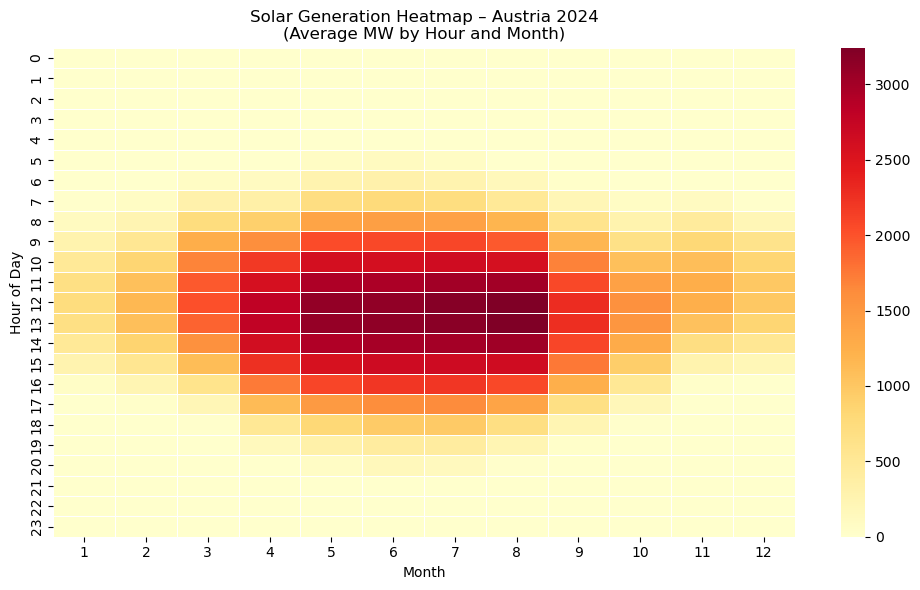

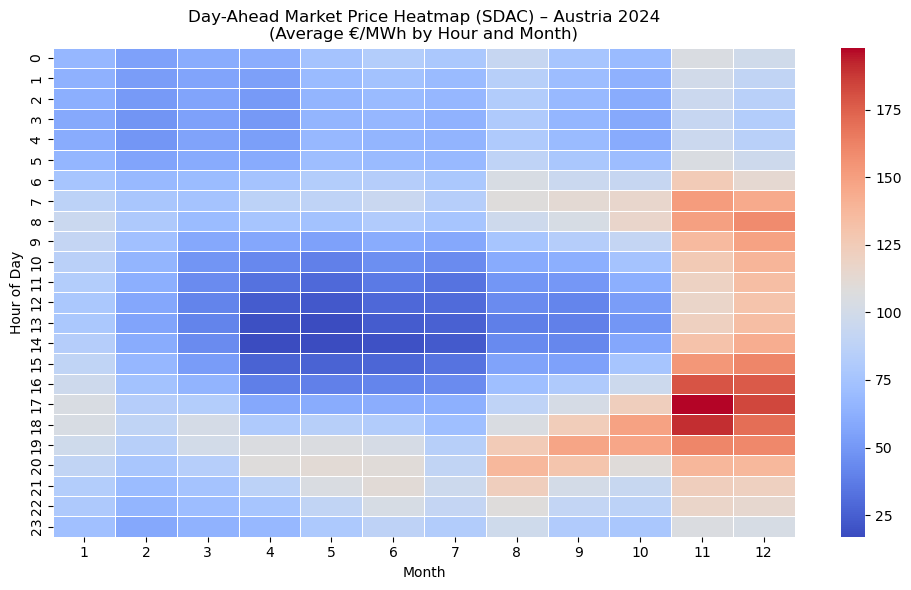

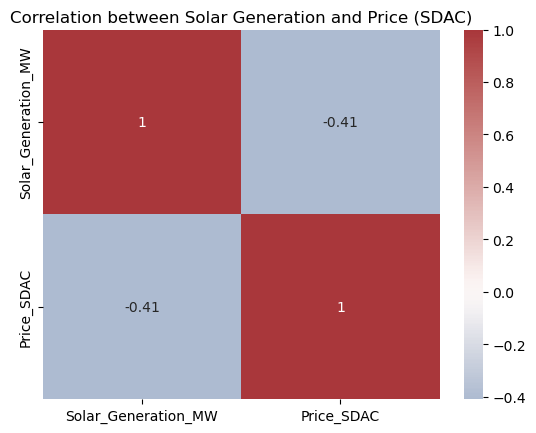

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make sure your merged dataset is ready
df = merged_sdac.copy()

# Convert to datetime if not already
df['Start'] = pd.to_datetime(df['Start'])

# Extract month and hour
df['Month'] = df['Start'].dt.month
df['Hour'] = df['Start'].dt.hour

# -------------------------------
# 1️⃣ Solar generation heatmap
# -------------------------------
solar_pivot = df.pivot_table(
    values='Solar_Generation_MW',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(solar_pivot, cmap='YlOrRd', linewidths=0.5)
plt.title("Solar Generation Heatmap – Austria 2024\n(Average MW by Hour and Month)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

# -------------------------------
# 2️⃣ SDAC price heatmap
# -------------------------------
price_pivot = df.pivot_table(
    values='Price_SDAC',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(price_pivot, cmap='coolwarm', linewidths=0.5)
plt.title("Day-Ahead Market Price Heatmap (SDAC) – Austria 2024\n(Average €/MWh by Hour and Month)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

# Optional: show correlation heatmap between variables
corr = df[['Solar_Generation_MW', 'Price_SDAC']].corr()
sns.heatmap(corr, annot=True, cmap='vlag', center=0)
plt.title("Correlation between Solar Generation and Price (SDAC)")
plt.show()


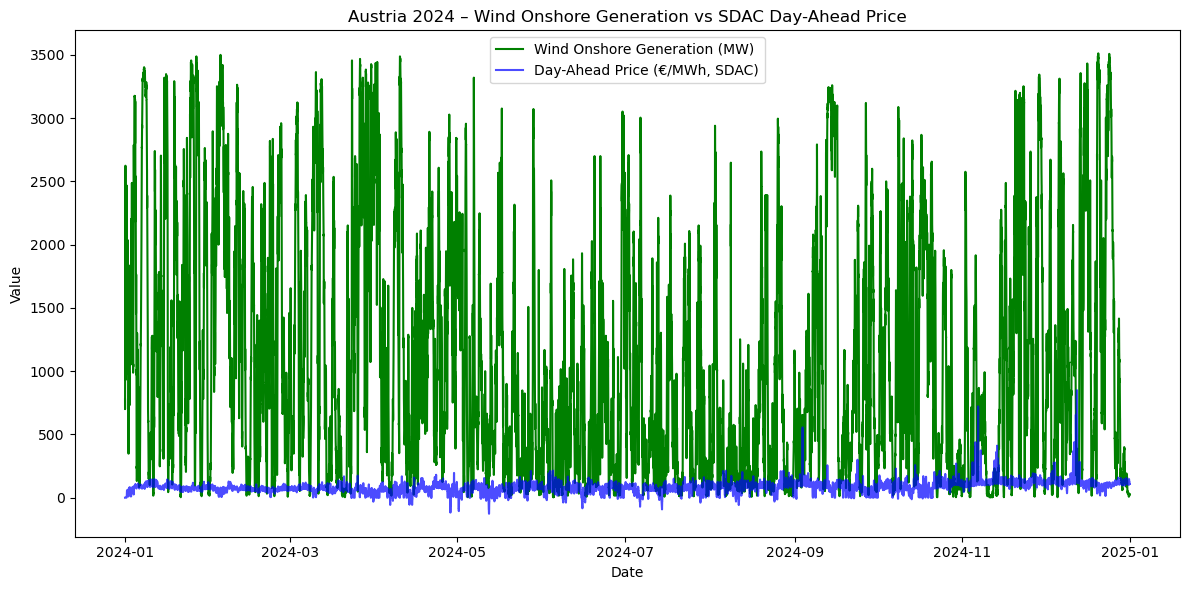

Correlation (Wind Onshore vs SDAC Price): -0.104


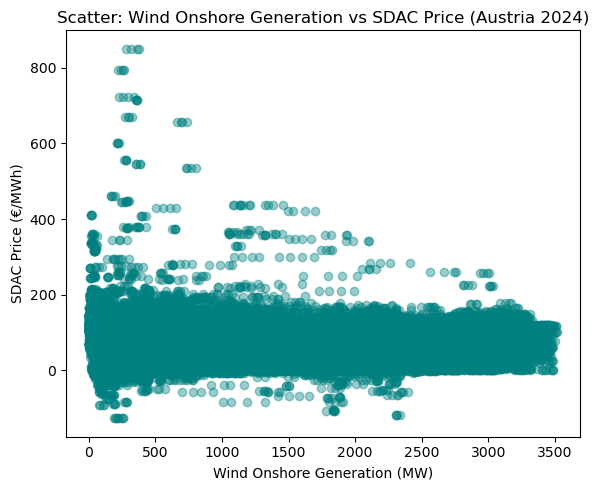

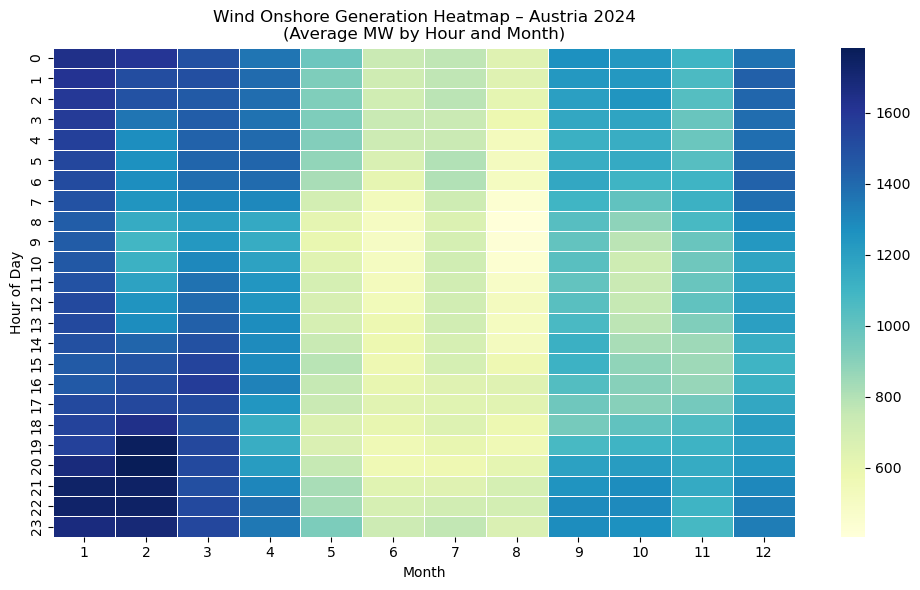

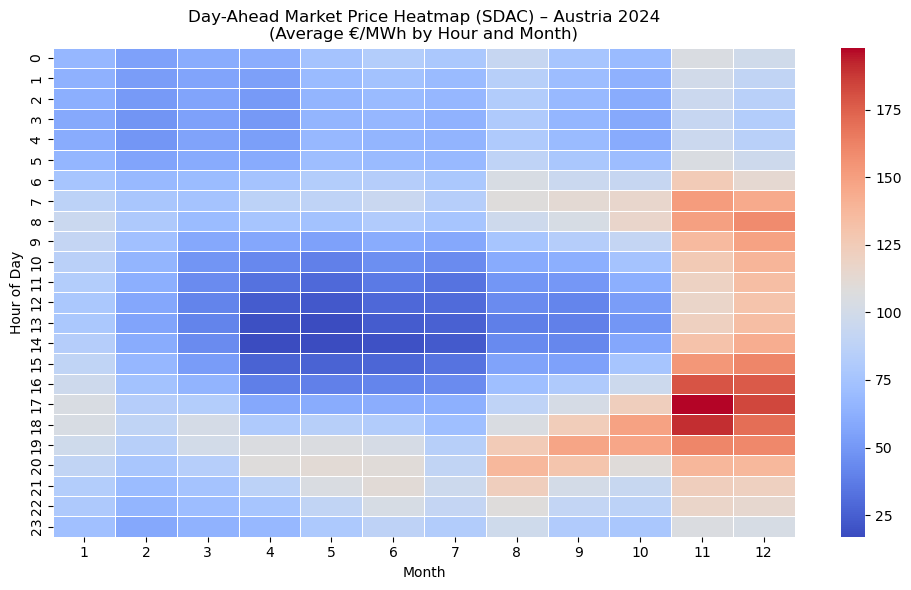

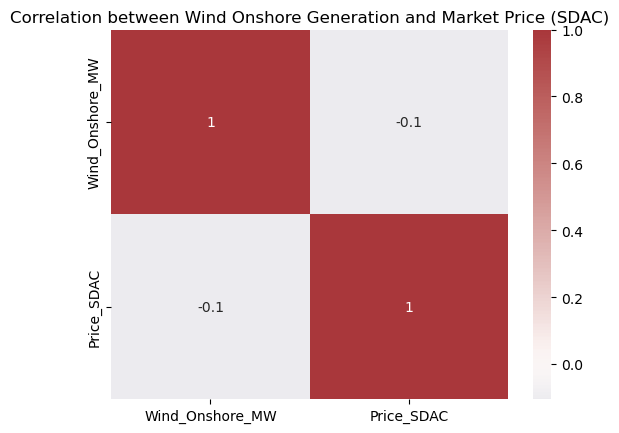

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1️⃣ Filter Wind Onshore generation
# -------------------------------

# Assuming you already have 'gen_df' and 'price_df' loaded (like before)
wind_df = gen_df[gen_df[gen_type_col].astype(str).str.contains('Wind Onshore', case=False, na=False)].copy()

# Clean numeric and prepare
wind_df["Wind_Onshore_MW"] = pd.to_numeric(wind_df[gen_value_col].astype(str).str.replace(",", "."), errors="coerce")

# Keep only relevant columns
wind_df = wind_df[["Start", "Wind_Onshore_MW"]].groupby("Start", as_index=False).sum()

# Merge with SDAC prices (you already have price_sdac prepared)
merged_wind_sdac = pd.merge(wind_df, price_sdac, on="Start", how="inner").sort_values("Start")

# -------------------------------
# 2️⃣ Visualization: Time series
# -------------------------------

plt.figure(figsize=(12,6))
plt.plot(merged_wind_sdac["Start"], merged_wind_sdac["Wind_Onshore_MW"], label="Wind Onshore Generation (MW)", color="green")
plt.plot(merged_wind_sdac["Start"], merged_wind_sdac["Price_SDAC"], label="Day-Ahead Price (€/MWh, SDAC)", color="blue", alpha=0.7)
plt.title("Austria 2024 – Wind Onshore Generation vs SDAC Day-Ahead Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Correlation + Scatter
# -------------------------------

corr_wind_sdac = merged_wind_sdac["Wind_Onshore_MW"].corr(merged_wind_sdac["Price_SDAC"])
print(f"Correlation (Wind Onshore vs SDAC Price): {corr_wind_sdac:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(merged_wind_sdac["Wind_Onshore_MW"], merged_wind_sdac["Price_SDAC"], alpha=0.4, color="teal")
plt.title("Scatter: Wind Onshore Generation vs SDAC Price (Austria 2024)")
plt.xlabel("Wind Onshore Generation (MW)")
plt.ylabel("SDAC Price (€/MWh)")
plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Heatmaps
# -------------------------------

df = merged_wind_sdac.copy()
df['Start'] = pd.to_datetime(df['Start'])
df['Month'] = df['Start'].dt.month
df['Hour'] = df['Start'].dt.hour

# --- Wind Onshore Heatmap ---
wind_pivot = df.pivot_table(
    values='Wind_Onshore_MW',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(wind_pivot, cmap='YlGnBu', linewidths=0.5)
plt.title("Wind Onshore Generation Heatmap – Austria 2024\n(Average MW by Hour and Month)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

# --- Price Heatmap (same time window) ---
price_pivot = df.pivot_table(
    values='Price_SDAC',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(price_pivot, cmap='coolwarm', linewidths=0.5)
plt.title("Day-Ahead Market Price Heatmap (SDAC) – Austria 2024\n(Average €/MWh by Hour and Month)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
corr = df[['Wind_Onshore_MW', 'Price_SDAC']].corr()
sns.heatmap(corr, annot=True, cmap='vlag', center=0)
plt.title("Correlation between Wind Onshore Generation and Market Price (SDAC)")
plt.show()
